In [1]:
import pandas as pd 
from subs.energy_api import *


df_carbon_forecast_indexed =carbon_api_forecast()


In [2]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-02-11 14:30:00,CO2_INTENSITY_FORECAST,ALL,217.0066
2024-02-11 15:00:00,CO2_INTENSITY_FORECAST,ALL,223.2054
2024-02-11 15:30:00,CO2_INTENSITY_FORECAST,ALL,225.9793
2024-02-11 16:00:00,CO2_INTENSITY_FORECAST,ALL,225.6376
2024-02-11 16:30:00,CO2_INTENSITY_FORECAST,ALL,228.8085
2024-02-11 17:00:00,CO2_INTENSITY_FORECAST,ALL,226.1296
2024-02-11 17:30:00,CO2_INTENSITY_FORECAST,ALL,229.3056
2024-02-11 18:00:00,CO2_INTENSITY_FORECAST,ALL,223.1540
2024-02-11 18:30:00,CO2_INTENSITY_FORECAST,ALL,225.4821


In [3]:
co2_stats_prior_day, df_carbon_intensity_recent = carbon_api_intensity()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carbon_intensity_recent["Value"] = df_carbon_intensity_recent[


In [4]:
df_carbon_intensity_recent

,FieldName,Region,Value
EffectiveTime,,,
2024-02-10 14:45:00,CO2_INTENSITY,ALL,253.0
2024-02-10 15:00:00,CO2_INTENSITY,ALL,249.0
2024-02-10 15:15:00,CO2_INTENSITY,ALL,247.0
2024-02-10 15:30:00,CO2_INTENSITY,ALL,248.0
2024-02-10 15:45:00,CO2_INTENSITY,ALL,252.0
...,...,...,...
2024-02-11 13:15:00,CO2_INTENSITY,ALL,203.0
2024-02-11 13:30:00,CO2_INTENSITY,ALL,205.0
2024-02-11 13:45:00,CO2_INTENSITY,ALL,205.0


In [5]:
co2_stats_prior_day

{'mean': 228.37894736842105, 'min': 180.0, 'max': 254.0}

In [6]:
df_ = status_classification(df_carbon_forecast_indexed,co2_stats_prior_day)

<module 'matplotlib.pyplot' from '/Users/saeed/anaconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

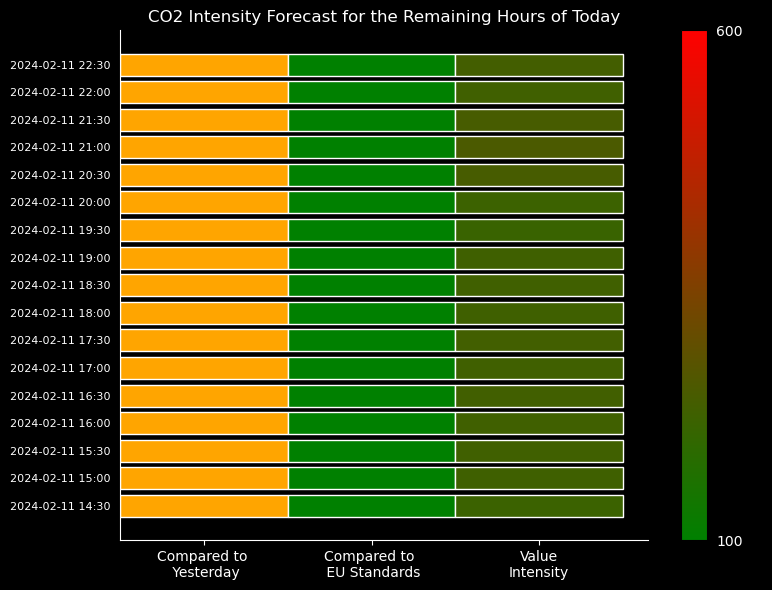

In [7]:
co2_int_plot(df_)

In [8]:
df_.Value.values

array([217.0066, 223.2054, 225.9793, 225.6376, 228.8085, 226.1296,
       229.3056, 223.154 , 225.4821, 223.5556, 212.576 , 218.49  ,
       239.2514, 246.6755, 239.7691, 226.0409, 232.6208])

In [25]:
def create_message(forecast_start_date, co2_values):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    co2_values_str = ', '.join(str(value) for value in co2_values)
    system_template = (
        f"The following data is about the forecasted CO2 emissions starting from {forecast_start_date} "
        f"until the end of today with a step of 30 minutes. Each value represents the CO2 intensity in grams per kWh. "
        f"Your task is to explain this information simply to the user, like a weather commentator. "
        f"\n\nCO2 values are: {co2_values_str}"
    )

    user_template = "When is the best and worst time to use energy today?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m

# Example usage
msg = create_message(
    forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values
)

m = create_message(
    forecast_start_date="2024-02-08 22:00:00", co2_values=df_.Value.values
)

messages = [
    {"role": "system", "content": msg.system},
    {"role": "user", "content": msg.user},
]


messages = [
    {"role": "system", "content": m.system},
    {"role": "user", "content": m.user},
]

print(messages)


[{'role': 'system', 'content': 'The following data is about the forecasted CO2 emissions starting from 2024-02-08 22:00:00 until the end of today with a step of 30 minutes. Each value represents the CO2 intensity in grams per kWh. Your task is to explain this information simply to the user, like a weather commentator. \n\nCO2 values are: 198.4955, 203.3778, 216.6131, 218.7606, 219.6809, 219.1306'}, {'role': 'user', 'content': 'When is the best and worst time to use energy today?'}]


In [19]:
import openai
import os
import datetime
from datetime import timedelta


def create_message(forecast_start_date, co2_values,user_name):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    start_datetime = datetime.datetime.strptime(forecast_start_date, "%Y-%m-%d %H:%M:%S")
    
    # Generate hours list based on the start_datetime and the length of co2_values
    hours = [(start_datetime + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(len(co2_values))]
    
    time_with_co2 = ", ".join(
        f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, co2_values)
    )

    # system_template = (
    #     f"Forecasted CO2 emissions data from {forecast_start_date}, updating every 30 minutes, is provided below. "
    #     f"Based on this, you are to give energy usage advice. Identify the most environmentally friendly hours "
    #     f"for energy consumption to minimize environmental impact, they are hours with the lowest values. Use the format: Most environmental friendly hours hh:mm, "
    #     f"hh:mm. Consider high CO2 > 500, low CO2 < 250, and medium for values in between and mention them if and only if any exists "
    #     f"\n\nCO2 values and corresponding times are: {time_with_co2}"
    #     f"\n\nProvide advice on the optimal time periods for energy consumption, do not need to give CO2 values to users."
    #     f"\n\n start with greeting user {user_name}, based on time {forecast_start_date}. Don't tell them they can ask questions. "
    # )
    system_template = (
            f"Hello {user_name}! Based on the forecasted CO2 emissions data from {forecast_start_date}, "
            "here is a summary of the energy consumption advice: \n\n"
            "Please identify the hours with the lowest CO2 values as the most environmentally friendly "
            "hours for energy consumption. Also, highlight any periods with high CO2 emissions that should be avoided. "
            "The aim is to provide a concise summary indicating the best and worst times for energy usage today, "
            "with a focus on minimizing environmental impact. \n\n"
            "The CO2 values and corresponding times are provided for your analysis. "
            "Generate a summary that categorizes the day into the lowest, medium, and highest CO2 emission periods, "
            "without suggesting further questions or interactions. \n\n"
            "CO2 values and times: {time_with_co2}"
        )

    user_template = "When are the best and worst time periods, on average, to use energy today from the environmental impact perspective in format of hour:minute?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m


def opt_gpt_summarise():
    # Ensure your API key is correctly set in your environment variables
    openai.api_key = os.getenv("OPENAI_API_KEY")

    # Construct the messages
    msg = create_message(
        forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values,user_name = 'Saeed'
    )

    messages = [
        {"role": "system", "content": msg.system}
        # {"role": "user", "content": msg.user},
    ]

    try:
        # Making the API call
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or "gpt-3.5-turbo" based on your subscription
            messages=messages,
            temperature= 1,
            max_tokens=600,  # Adjust the number of tokens as needed
            n=1,  # Number of completions to generate
            stop=None,  # Specify any stopping criteria if needed
        )

        # Extracting the response
        # generated_text = response.choices[0].message['content'].strip()
        generated_text = response.choices[0].message.content.strip()

        return generated_text
    except Exception as e:
        return str(e)


In [20]:
opt_gpt_summarise()

'Based on the forecasted CO2 emissions data for today, here is a summary of the energy consumption advice:\n\nLowest CO2 Emission Periods:\n1. 15:00 - 17:00: CO2 emissions are expected to be at their lowest during this time.\n2. 21:00 - 23:00: Another period with low CO2 emissions, making it an environmentally friendly choice for energy consumption.\n\nMedium CO2 Emission Periods:\n1. 11:00 - 13:00: Although not the lowest, CO2 emissions during this time are relatively moderate.\n\nHighest CO2 Emission Periods (to be avoided if possible):\n1. 07:00 - 09:00: CO2 emissions are expected to be at their highest during this time.\n2. 18:00 - 20:00: Another period with high CO2 emissions, indicating a potential peak in energy demand.\n\nBy aligning your energy consumption with the periods of lowest CO2 emissions, you can minimize your environmental impact. Avoiding energy usage during the highest CO2 emission periods can also help reduce your carbon footprint.'

In [23]:
df_

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-11 14:30:00,CO2_INTENSITY_FORECAST,ALL,217.0066,medium,low
2024-02-11 15:00:00,CO2_INTENSITY_FORECAST,ALL,223.2054,medium,low
2024-02-11 15:30:00,CO2_INTENSITY_FORECAST,ALL,225.9793,medium,low
2024-02-11 16:00:00,CO2_INTENSITY_FORECAST,ALL,225.6376,medium,low
2024-02-11 16:30:00,CO2_INTENSITY_FORECAST,ALL,228.8085,medium,low
2024-02-11 17:00:00,CO2_INTENSITY_FORECAST,ALL,226.1296,medium,low
2024-02-11 17:30:00,CO2_INTENSITY_FORECAST,ALL,229.3056,medium,low
2024-02-11 18:00:00,CO2_INTENSITY_FORECAST,ALL,223.1540,medium,low
2024-02-11 18:30:00,CO2_INTENSITY_FORECAST,ALL,225.4821,medium,low


In [25]:
import pandas as pd

# Sample DataFrame setup
# data = {
#     'EffectiveTime': [
#         '2024-02-11 14:30:00', '2024-02-11 15:00:00', '2024-02-11 15:30:00',
#         # Add more timestamps as needed
#     ],
#     'Value': [
#         217.0066, 223.2054, 225.9793,
#         # Add more values as needed
#     ],
#     'status_compared_to_yesterday': [
#         'medium', 'medium', 'medium',
#         # Add more statuses as needed
#     ],
#     'status_compared_to_EU': [
#         'low', 'low', 'low',
#         # Add more EU statuses as needed
#     ],
# }
# df = pd.DataFrame(data)
# df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])
# df.set_index('EffectiveTime', inplace=True)

# Assuming thresholds for CO2 values: low < 200, 200 <= medium < 300, high >= 300
# These thresholds can be adjusted based on your data and requirements

def categorize_periods(df):
    low_periods = df[df['Value'] < 250]
    medium_periods = df[(df['Value'] >= 250) & (df['Value'] < 500)]
    high_periods = df[df['Value'] >= 500]
    
    # Here you can implement logic to find continuous periods within each category
    # For simplicity, this example will just return the start and end times for each category
    
    summary = {
        'Low CO2 Emission Periods': [low_periods.index.min(), low_periods.index.max()],
        'Medium CO2 Emission Periods': [medium_periods.index.min(), medium_periods.index.max()],
        'High CO2 Emission Periods': [high_periods.index.min(), high_periods.index.max()],
    }
    
    # Formatting summary for GPT model
    summary_text = "Based on the forecasted CO2 emissions data for today, here is a summary:\n\n"
    for category, periods in summary.items():
        if pd.notna(periods[0]) and pd.notna(periods[1]):  # Check if periods are not empty
            start_time = periods[0].strftime('%H:%M')
            end_time = periods[1].strftime('%H:%M')
            summary_text += f"{category}: from {start_time} to {end_time}.\n"
        else:
            summary_text += f"{category}: No specific periods identified.\n"
    
    return summary_text

summary_text = categorize_periods(df_)
print(summary_text)


Based on the forecasted CO2 emissions data for today, here is a summary:

Low CO2 Emission Periods: from 14:30 to 22:30.
Medium CO2 Emission Periods: No specific periods identified.
High CO2 Emission Periods: No specific periods identified.

